<a href="https://colab.research.google.com/github/23f1000208/Physics-Inspired-Machine-Learning/blob/main/CH_3__regularization_lasso_ridge_elastic_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 🧭 How to Use This Notebook
* 🔽 **Work top-to-bottom.** Read the explanations, then run each code cell by clicking the play button ▶️
* 💡 **Don’t worry if you don’t understand everything immediately.** Machine learning takes practice!


# ✨ Regularization: Lasso, Ridge & Elastic Net Regression Models

## Abstract

Regularization is one of the most practical upgrades you can make to linear regression when features are correlated, noisy, or only weakly predictive. In this notebook, we’ll learn how **Ridge (L2)**, **Lasso (L1)**, and **Elastic Net (L1+L2)** control model complexity by shrinking coefficients—improving generalization, stabilizing estimates under multicollinearity, and (in Lasso’s case) performing **automatic feature selection**. We’ll apply these ideas to the **Wine Quality – Red** dataset (1599 wines, 11 physicochemical measurements) to predict the sensory **quality** score and see how different penalties change both performance and interpretability.

🚀 **By the end of this notebook, you will** build leakage-safe, reproducible regression pipelines; tune and compare Ridge, Lasso, and Elastic Net with cross-validation; and interpret how regularization reshapes coefficients and test-set performance.

**In this notebook, we will:**
- 🧰 Install required packages and import libraries in a clean, consistent setup
- 📥 Load the Wine Quality – Red dataset and validate schema (shapes, dtypes, missing/duplicates)
- ♻️ Ensure reproducibility: record versions, set seeds, and configure display options
- 🎯 Define the regression task and evaluation criteria (RMSE/MAE + R²) with a clear model-selection rule
- ✂️ Create a train/test split and a K-fold cross-validation plan for fair hyperparameter selection
- 🔎 Perform EDA for linear modeling: distributions, outliers, relationships, and correlation-driven multicollinearity
- 🛡️ Decide preprocessing needs (especially scaling) and prevent data leakage during CV
- 🧱 Build leakage-safe **scikit-learn Pipelines** (scaler + estimator) for consistent training and evaluation
- 📉 Establish baselines with **DummyRegressor** and **Ordinary Least Squares**, and discuss overfitting risks
- 💡 Develop intuition: shrinkage, sparsity, and the **bias–variance trade-off**
- 🧾 Compare objectives: Ridge vs Lasso vs Elastic Net loss functions and their behavior under correlation
- 🟦 Train **Ridge** across α values, visualize coefficient shrinkage paths, and select α via CV
- 🟥 Train **Lasso** across α values, observe coefficients hitting exactly zero, and discuss instability scenarios
- 🟪 Train **Elastic Net**, tuning both α and **l1_ratio** to balance sparsity and stability
- 🔧 Tune hyperparameters with **GridSearchCV/RandomizedSearchCV**, comparing mean performance and fold variability
- 🧪 Refit best models and evaluate on the held-out test set (RMSE/MAE/R²) to summarize generalization trade-offs
- 🧭 Interpret standardized coefficients across OLS/Ridge/Lasso/Elastic Net to identify consistent predictors
- 🧯 Run residual diagnostics to spot systematic bias and failure modes of linear assumptions

## 🎲 (Optional) Physics-Inspired Bias–Variance Tradeoff & Regularization Concepts

While the rest of this course is independent of physics-inspired concepts, the following videos are **recommended** to gain deeper intuition about the underlying ideas.

### 🎯 Recommended Videos

- **The Lagrange Multiplier “Method” of Machine Learning (Regularization)**  
  https://youtu.be/NAyy4Eip8_U?si=desE1vHoaMMAg1oQ

- **The Heisenberg “Principle” of Machine Learning (Bias–Variance Tradeoff)**  
  https://youtu.be/FbFZQUw52b4?si=5AhHGwuRhe8NzzBX

> These resources provide intuitive, physics-inspired perspectives that can help clarify why regularization and the bias–variance tradeoff arise in machine learning models.



## 🛠️ Setup

In this course, we will use a few Python packages. Run the following cell to make sure they are installed.


In [ ]:
!pip -q install numpy pandas matplotlib seaborn scikit-learn


---

## 📦 Imports

Let's also import all the packages that we need during the course.



In [ ]:
import os
import sys
import platform
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold,
    cross_validate,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

In [ ]:

## set the color themes of the figures
import requests
style = requests.get("https://compu-flair.com/notes/jupyter-color-style/raw").text
exec(style)

## ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")


<string>:134: AltairDeprecationWarning: 
Deprecated since `altair=5.5.0`. Use altair.theme instead.
Most cases require only the following change:

    # Deprecated
    alt.themes.enable('quartz')

    # Updated
    alt.theme.enable('quartz')

If your code registers a theme, make the following change:

    # Deprecated
    def custom_theme():
        return {'height': 400, 'width': 700}
    alt.themes.register('theme_name', custom_theme)
    alt.themes.enable('theme_name')

    # Updated
    @alt.theme.register('theme_name', enable=True)
    def custom_theme():
        return alt.theme.ThemeConfig(
            {'height': 400, 'width': 700}
        )

See the updated User Guide for further details:
    https://altair-viz.github.io/user_guide/api.html#theme
    https://altair-viz.github.io/user_guide/customization.html#chart-themes


## 📊 Data

In this course, we will work with the **Wine Quality - Red (OpenML/UCI)** dataset and would like to use **Regularization: Lasso, Ridge & Elastic Net Regression Models** to **predict the wine quality score (`quality`)** from 11 physicochemical measurements (e.g., acidity, sugar, pH, density). We will discuss dataset's details later. For now, let's just load the data.

We will download the dataset from **OpenML** using `fetch_openml`, store it as a pandas DataFrame, then split it into features **X** (all columns except `quality`) and target **y** (the `quality` column).

In [ ]:
from sklearn.datasets import fetch_openml

dataset = fetch_openml(name="wine-quality-red", version=1, as_frame=True)
df = dataset.frame

target_col = dataset.target_names[0] if isinstance(dataset.target_names, (list, tuple)) else dataset.target_names
X = df.drop(columns=[target_col])
y = df[target_col]

dataset, df.head()

({'data':       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
  0               7.4             0.700         0.00             1.9      0.076   
  1               7.8             0.880         0.00             2.6      0.098   
  2               7.8             0.760         0.04             2.3      0.092   
  3              11.2             0.280         0.56             1.9      0.075   
  4               7.4             0.700         0.00             1.9      0.076   
  ...             ...               ...          ...             ...        ...   
  1594            6.2             0.600         0.08             2.0      0.090   
  1595            5.9             0.550         0.10             2.2      0.062   
  1596            6.3             0.510         0.13             2.3      0.076   
  1597            5.9             0.645         0.12             2.0      0.075   
  1598            6.0             0.310         0.47             3.6      0.067


## 🔍 Inspecting the Dataset Object

Before we dive into the data itself, let's inspect the object we just loaded. This will help us understand how the data is stored and where to find important information like the dataset description or feature names.


In [ ]:
# Inspect dataset object (assumes `dataset` is already loaded in Cell 1)
print("Dataset type:", type(dataset))

if hasattr(dataset, "keys"):
    keys = list(dataset.keys())
    print("Dataset keys:", keys)
    print("Contains 'DESCR'?:", "DESCR" in keys)
    if "DESCR" in keys:
        print("\n--- DESCR (first 1000 chars) ---")
        print(str(dataset["DESCR"])[:1000])
else:
    print("Dataset has no .keys(); listing attributes instead:")
    attrs = [a for a in dir(dataset) if not a.startswith("_")]
    print("Attributes:", attrs)
    print("Has attribute 'DESCR'?:", hasattr(dataset, "DESCR"))
    if hasattr(dataset, "DESCR"):
        print("\n--- DESCR (first 1000 chars) ---")
        print(str(getattr(dataset, "DESCR"))[:1000])

# Also check common OpenML description fields
for name in ["details", "description", "metadata", "categories"]:
    if hasattr(dataset, name):
        print(f"\nHas attribute '{name}':", True)
        try:
            val = getattr(dataset, name)
            if isinstance(val, str):
                print(f"'{name}' (first 1000 chars):\n", val[:1000])
            else:
                print(f"'{name}' type:", type(val))
                if hasattr(val, "keys"):
                    print(f"'{name}' keys:", list(val.keys()))
        except Exception as e:
            print(f"Error accessing '{name}':", e)

Dataset type: <class 'sklearn.utils._bunch.Bunch'>
Dataset keys: ['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']
Contains 'DESCR'?: True

--- DESCR (first 1000 chars) ---
wine-quality-red-pmlb

Downloaded from openml.org.

Has attribute 'details': True
'details' type: <class 'dict'>
'details' keys: ['id', 'name', 'version', 'description_version', 'format', 'upload_date', 'licence', 'url', 'parquet_url', 'file_id', 'default_target_attribute', 'tag', 'visibility', 'status', 'processing_date', 'md5_checksum']

Has attribute 'categories': True
'categories' type: <class 'NoneType'>


## 📚 Learn more about data

🔎 **We always want to learn the column names of dataset and what they actually mean (attribute information)**

The feature and target **names** are available directly on the OpenML `Bunch` object via `dataset.feature_names` (inputs) and `dataset.target_names` / `dataset.details["default_target_attribute"]` (target). The **descriptions/attribute information** (what each column means) are stored in the dataset documentation text `dataset.DESCR`, and you can also inspect the actual column names in the combined table `dataset.frame` (or `df.columns`) where the target column matches `target_col`.

In [ ]:
# Display feature/target names and available descriptions for the OpenML dataset

from textwrap import shorten

# --- Basic structure ---
print("OpenML dataset name:", dataset.details.get("name", "<unknown>"))
print("OpenML id/version:", dataset.details.get("id", "<unknown>"), "/", dataset.details.get("version", "<unknown>"))
print("URL:", dataset.details.get("url", dataset.url))

# --- Target info ---
target_col = dataset.target_names[0] if isinstance(dataset.target_names, (list, tuple)) else dataset.target_names
print("\nTarget column:", target_col)
print("Target dtype:", df[target_col].dtype)
print("Target value counts (top 20):")
print(df[target_col].value_counts(dropna=False).head(20))

# --- Feature info ---
print("\nNumber of features:", X.shape[1])
print("Feature names:")
for i, name in enumerate(list(X.columns), start=1):
    print(f"  {i:02d}. {name} (dtype={X[name].dtype})")

# --- Descriptions (OpenML provides a combined text description via DESCR) ---
print("\n--- Dataset DESCR (full) ---")
print(dataset.DESCR if hasattr(dataset, "DESCR") else "<No DESCR available>")

# --- Optional: show OpenML details (often includes default target attribute etc.) ---
print("\n--- OpenML details (selected fields) ---")
for k in [
    "default_target_attribute",
    "description_version",
    "upload_date",
    "licence",
    "status",
    "processing_date",
    "tag",
]:
    if k in dataset.details:
        print(f"{k}: {dataset.details[k]}")

# --- If you want a shorter preview instead of full DESCR, uncomment:
# print("\n--- Dataset DESCR (preview) ---")
# print(shorten(dataset.DESCR, width=1500, placeholder=" ..."))

OpenML dataset name: wine-quality-red
OpenML id/version: 40691 / 1
URL: https://openml.org/data/v1/download/4965268/wine-quality-red.arff

Target column: class
Target dtype: category
Target value counts (top 20):
class
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

Number of features: 11
Feature names:
  01. fixed_acidity (dtype=float64)
  02. volatile_acidity (dtype=float64)
  03. citric_acid (dtype=float64)
  04. residual_sugar (dtype=float64)
  05. chlorides (dtype=float64)
  06. free_sulfur_dioxide (dtype=float64)
  07. total_sulfur_dioxide (dtype=float64)
  08. density (dtype=float64)
  09. pH (dtype=float64)
  10. sulphates (dtype=float64)
  11. alcohol (dtype=float64)

--- Dataset DESCR (full) ---
wine-quality-red-pmlb

Downloaded from openml.org.

--- OpenML details (selected fields) ---
default_target_attribute: class
description_version: 1
upload_date: 2017-04-06T12:14:58
licence: public
status: active
processing_date: 2018-10-04 07:19:40
tag

## 🧰 Course Setup, Versioning & Reproducibility

This step makes your notebook **reproducible** and your outputs easier to inspect.

- **Fixed random seed:** Many ML workflows rely on randomness (e.g., sampling, shuffling, randomized algorithms). Setting a single seed for both NumPy and Python’s random module ensures you can rerun the notebook and get the **same results**, which is essential for debugging, comparing experiments, and writing reliable reports.

- **Display settings for pandas:** Adjusting pandas display options helps tables render more readably in the notebook (e.g., showing more columns and using a wider display). This reduces confusion when inspecting datasets and intermediate results.

- **Environment version logging:** Printing the versions of Python, the operating system/platform, and key libraries (NumPy, pandas, scikit-learn, matplotlib, seaborn) creates a lightweight **audit trail**. If results differ across machines or over time, these version details are often the first place to look to understand why.

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("Python:", sys.version)
print("Platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
import sklearn
print("scikit-learn:", sklearn.__version__)
import matplotlib
print("matplotlib:", matplotlib.__version__)
import seaborn
print("seaborn:", seaborn.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1
matplotlib: 3.10.0
seaborn: 0.13.2


## 📦 Validate Dataset Schema

Before modeling, we need to confirm the dataset looks the way we expect and that we’re training on the right inputs and labels. This step performs a quick “sanity check” of the loaded data and prepares the basic split into features (`X`) and target (`y`).

**What this step accomplishes:**
- **Infers the target column** by looking for common target names (e.g., `quality`) and falls back to the **last column** if none are found. This helps ensure we’re predicting the intended outcome.
- **Separates features and target** so we have:
  - `X`: all input columns used for prediction
  - `y`: the target column we want to predict
- **Reports shapes** of `X` and `y` to confirm the number of rows match and the feature count is reasonable.
- **Summarizes feature data types** to catch issues like unexpected strings in numeric columns.
- **Checks data quality flags**:
  - **Missing values** (overall count and which columns have the most)
  - **Duplicate rows** (which can bias training and evaluation)
- **Shows the target distribution** (value counts) to understand how labels are spread and spot potential imbalance or unexpected values.

If the dataset isn’t a pandas DataFrame (e.g., it’s already provided as arrays), the step still reports the basic shapes and assigns default feature/target names so downstream steps have consistent metadata.

In [ ]:
target_name = None
feature_names = None

if "df" in globals() and isinstance(df, pd.DataFrame):
    # Attempt to infer target column for Wine Quality - Red
    candidate_targets = ["quality", "target", "y"]
    for c in candidate_targets:
        if c in df.columns:
            target_name = c
            break
    if target_name is None:
        # Fall back to last column as a reasonable default for supervised demos
        target_name = df.columns[-1]

    X = df.drop(columns=[target_name])
    y = df[target_name]
    feature_names = list(X.columns)

    print("Inferred target_name:", target_name)
    print("X shape:", X.shape, "y shape:", y.shape)
    print("X dtypes summary:")
    display(X.dtypes.value_counts())

    missing = df.isna().sum().sort_values(ascending=False)
    print("Missing values (top):")
    display(missing.head(10))
    print("Total missing:", int(missing.sum()))

    n_dups = int(df.duplicated().sum())
    print("Duplicate rows:", n_dups)

    print("Target distribution (value counts):")
    display(y.value_counts().sort_index())
else:
    # Array-based path
    print("Array-based dataset detected.")
    print("X:", type(X), getattr(X, "shape", None))
    print("y:", type(y), getattr(y, "shape", None))
    if isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
    elif hasattr(X, "shape"):
        feature_names = [f"x{i}" for i in range(X.shape[1])]
    target_name = "target"

Inferred target_name: class
X shape: (1599, 11) y shape: (1599,)
X dtypes summary:


,count
float64,11


Missing values (top):


,0
fixed_acidity,0
volatile_acidity,0
citric_acid,0
residual_sugar,0
chlorides,0
free_sulfur_dioxide,0
total_sulfur_dioxide,0
density,0
pH,0
sulphates,0


Total missing: 0
Duplicate rows: 240
Target distribution (value counts):


,count
class,
3,10
4,53
5,681
6,638
7,199
8,18


## 💡 Interpretation of the results

- You prepared a supervised dataset by inferring the target column as class and using it as y. The feature matrix X has shape (1599, 11) and the target y has shape (1599,), indicating 1599 samples with 11 numeric features.

- All 11 features are float64, so the inputs are purely numeric with consistent data types.

- There are no missing values reported for the features, suggesting a clean numeric dataset for modeling.

- Duplicate rows are present (240 duplicates). This redundancy can bias training and evaluation, so handling duplicates (e.g., deduplication) is advisable before modeling.

- The class distribution is imbalanced: counts are 3:10, 4:53, 5:681, 6:638, 7:199, 8:18. Most samples fall into classes 5 and 6, while classes 3 and 8 are underrepresented. This imbalance can affect model learning and performance metrics.

- Overall takeaway: the data are clean and numeric (good for modeling), but you should address duplicates and consider class-imbalance strategies to ensure robust training and evaluation.

## 📏 Define the Regression Task & Evaluation Criteria

In this project, the goal is a **regression** task: use a wine’s physicochemical measurements (features) to **predict its quality score** (the numeric target).

To compare models fairly and consistently, we set **evaluation criteria** up front:

- **Primary metric: RMSE (Root Mean Squared Error)**  
  RMSE summarizes how far predictions are from the true quality scores, in the same units as the target. **Lower RMSE is better**, and because it squares errors, it places more weight on larger mistakes—useful when big misses are especially undesirable.

- **Secondary metrics: MAE and R²**  
  - **MAE** (lower is better) provides an easy-to-interpret average absolute error.  
  - **R²** (higher is better) indicates how much of the variation in quality is explained by the model.

Finally, we define a **clear model-selection rule** to avoid ambiguity: choose the model with the **lowest mean cross-validated RMSE**, and if two models are very close, **break ties by preferring the higher mean cross-validated R²**. This ensures model comparisons are objective and repeatable.

In [ ]:
# Task: predict wine quality (an integer score) from physicochemical features.
# Primary metric: RMSE (lower is better). Secondary: MAE (lower), R^2 (higher).

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

model_selection_rule = {
    "primary": "rmse",
    "secondary": ["mae", "r2"],
    "choose": "lowest mean CV RMSE; break ties by higher mean CV R^2",
}
print(model_selection_rule)

{'primary': 'rmse', 'secondary': ['mae', 'r2'], 'choose': 'lowest mean CV RMSE; break ties by higher mean CV R^2'}


## 🧪 Create Train/Test Split & Cross-Validation Plan

This step sets up a reliable evaluation workflow by separating data for **model selection** vs. **final assessment**:

- **Hold out a test set (20%)**: A portion of the data is reserved as `X_test, y_test` and is not used during training or tuning. This gives an unbiased estimate of how well the chosen model is likely to perform on new, unseen data.

- **Train on the remaining data (80%)**: The remaining data (`X_train, y_train`) is used for fitting models and comparing options.

- **Define a 5-fold cross-validation strategy on the training set**: `KFold` splits the training data into 5 different train/validation folds (with shuffling). This helps you evaluate hyperparameters more robustly than relying on a single validation split.

- **Reproducibility**: Using a fixed `random_state` makes the split and fold assignments repeatable, which is important for debugging and fair comparisons.

The printed shapes confirm the split sizes and help verify that the data partitioning looks as expected.

In [ ]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

print("Train:", getattr(X_train, "shape", None), getattr(y_train, "shape", None))
print("Test:", getattr(X_test, "shape", None), getattr(y_test, "shape", None))
print("CV:", cv)

Train: (1279, 11) (1279,)
Test: (320, 11) (320,)
CV: KFold(n_splits=5, random_state=42, shuffle=True)


## 🔎 Exploratory Data Analysis for Linear Modeling

Before fitting a linear model, it’s useful to **inspect what the data looks like** and whether the assumptions behind simple linear relationships are plausible. This step performs a compact EDA focused on what matters most for linear models.

**What we examine:**

- **Target distribution (quality):** A histogram (with a smooth density curve) shows how the target values are spread. This helps you notice skew, unusual shapes, and potential outliers that can affect model fit and error behavior.

- **Feature distributions:** Small-multiple histograms for each feature reveal differences in scale, skewness, and the presence of extreme values. These patterns can influence how well a linear model captures relationships and whether certain features might dominate due to scale or outliers.

- **Feature–feature correlations (multicollinearity check):** A correlation heatmap highlights pairs (or groups) of features that move together strongly. High multicollinearity can make linear model coefficients unstable and hard to interpret—one reason regularization methods (like Ridge/Lasso) are often helpful.

- **Feature–target correlations (linear signal indicator):** Ranking correlations with the target provides a quick sense of which features have the strongest *linear* association with the outcome. This is not a full feature selection method, but it’s a useful diagnostic for which variables may carry the most linear signal.

**If the inputs aren’t a labeled DataFrame:** the step falls back to a minimal check of the **target distribution**, since feature names and correlations aren’t available in the same way.

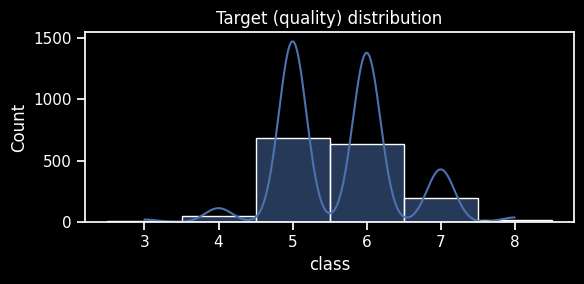

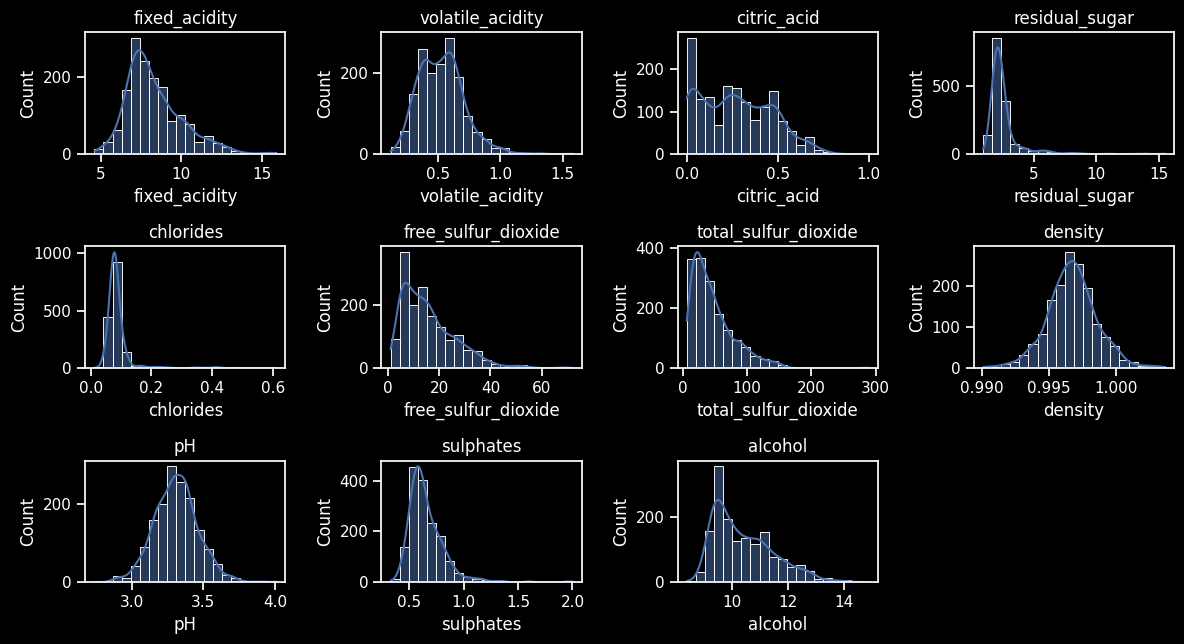

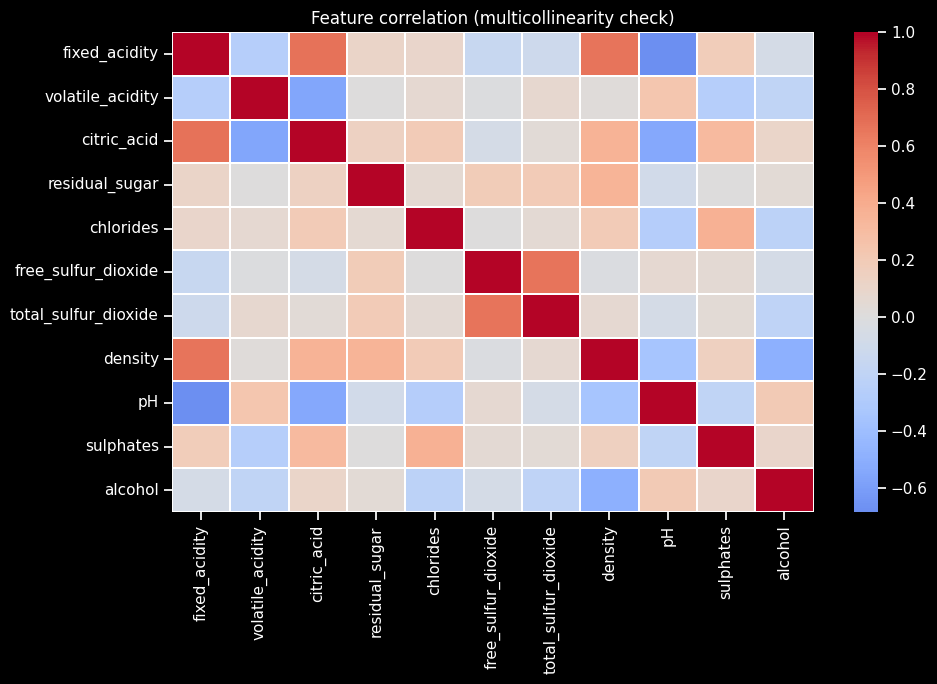

Top absolute correlations with target:


,0
alcohol,0.476166
volatile_acidity,-0.390558
sulphates,0.251397
citric_acid,0.226373
total_sulfur_dioxide,-0.185100
density,-0.174919
chlorides,-0.128907
fixed_acidity,0.124052
pH,-0.057731
free_sulfur_dioxide,-0.050656


In [ ]:
if isinstance(X, pd.DataFrame):
    y_series = y if isinstance(y, pd.Series) else pd.Series(y, name=getattr(y, "name", None) or "target")
    if y_series.name is None:
        y_series.name = "target"

    num_df = pd.concat([X, y_series.rename("target")], axis=1)

    # Target distribution
    plt.figure(figsize=(6, 3))
    sns.histplot(y_series, bins=12, kde=True)
    plt.title("Target (quality) distribution")
    plt.tight_layout()
    plt.show()

    # Feature distributions (small multiples)
    cols = list(X.columns)
    n = len(cols)
    ncols = 4
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 2.2 * nrows))
    axes = np.array(axes).reshape(-1)

    for ax, c in zip(axes, cols):
        s = X[c]
        if pd.api.types.is_numeric_dtype(s):
            sns.histplot(s.dropna(), bins=20, kde=True, ax=ax)
        else:
            vc = s.astype("string").value_counts(dropna=False).head(20)
            sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax)
            ax.tick_params(axis="x", rotation=45)
        ax.set_title(str(c))

    for ax in axes[len(cols):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Correlation heatmap to assess multicollinearity (numeric only)
    X_num = X.select_dtypes(include=[np.number])
    if X_num.shape[1] > 0:
        corr = X_num.corr()
        plt.figure(figsize=(10, 7))
        sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.2)
        plt.title("Feature correlation (multicollinearity check)")
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric features found for correlation heatmap.")

    # Correlation with target (numeric features only; ensure numeric y)
    y_num = pd.to_numeric(y_series, errors="coerce")
    if X_num.shape[1] > 0 and y_num.notna().any():
        df_corr = pd.concat([X_num, y_num.rename("target")], axis=1)
        df_corr = df_corr.dropna(subset=["target"])
        target_corr = df_corr[X_num.columns].corrwith(df_corr["target"]).sort_values(
            key=lambda s: s.abs(), ascending=False
        )
        print("Top absolute correlations with target:")
        display(target_corr.head(10))
    else:
        print("Skipping correlation with target (need numeric features and numeric target).")
else:
    y_series = y if isinstance(y, pd.Series) else pd.Series(y, name=getattr(y, "name", None) or "target")

    plt.figure(figsize=(6, 3))
    sns.histplot(y_series, bins=12, kde=True)
    plt.title("Target distribution")
    plt.tight_layout()
    plt.show()

## 💡 Interpretation of the results

Key observations from the outputs

- Target distribution (Image #0): The quality scores are not evenly spread. The histogram with a density curve suggests a mid-range concentration and a possible bimodal pattern, with fewer observations at the lower end (around 3–4) and the higher end (around 7–8). This hints at potential non-linearities or heterogeneous error behavior if modeled linearly.

- Feature distributions (Image #1): A grid of histograms shows most features are unimodal but on different scales, with some right-skewness and a few tight clusters. The varying spans and outliers imply that standardizing or normalizing features will be important for linear models, and that transformations could help stabilize relationships.

- Feature relationships (Image #2): The correlation heatmap shows a mix of strong positive (red) and some negative (blue) co-movements among features, with a bright diagonal indicating perfect self-correlation. The presence of off-diagonal strong correlations points to multicollinearity concerns for linear models.

- Relationships with the target (Text output): The top absolute correlations with the target are:
  - alcohol: strongest positive relationship (≈ 0.48)
  - volatile_acidity: strong negative relationship (≈ -0.39)
  - sulphates and citric_acid: moderate positive correlations (≈ 0.25 and ≈ 0.23)
  - other features (total_sulfur_dioxide, density, chlorides, fixed_acidity, pH, free_sulfur_dioxide): weaker but non-negligible relationships (roughly -0.19 to 0.13; pH and free_sulfur_dioxide near -0.06 and -0.05)
  - there are 10 features listed as top correlates, all shown as float64 (dtype: float64)



Implications for modeling and preprocessing

- Linear modeling readiness: Alcohol stands out as a key predictor, with a substantial positive association, while volatile_acidity pulls in the opposite direction. The moderate correlations for several other features suggest multiple inputs carry informative signal, but multicollinearity (as seen in the heatmap) could distort coefficient estimates without regularization or feature selection.

- Preprocessing recommendations: Because features vary in scale and show skewness/outliers, standardizing or normalizing is advisable. Consider transformations for skewed features. Perform regularization or feature selection to mitigate multicollinearity when fitting linear models.

- Modeling options: The target’s possibly bimodal distribution and the presence of non-linear patterns in features imply that nonlinear models or segmentation approaches could help if linear models underperform. The visuals reinforce the idea that a preprocessing + regularization approach is a solid starting point, with the caveat that non-linear methods might capture additional structure suggested by the target distribution.

Bottom line

- The data contain informative predictors (notably alcohol and volatile_acidity) but also show scale differences and multicollinearity that should be addressed in a linear modeling workflow. The visual and numeric cues align to guide preprocessing, feature handling, and model selection decisions.

## 🧼 Preprocessing Requirements

Many linear models are sensitive to the **scale of input features**. When predictors are on very different ranges (e.g., one feature in dollars, another in percentages), the regularization used by **Lasso** and **Elastic Net** can behave inconsistently—penalizing some coefficients more simply because their features are larger in magnitude. **Standardizing features** (e.g., with a `StandardScaler`) puts them on a comparable scale so the penalty is applied fairly across features. This is essential for Lasso/Elastic Net and often beneficial for Ridge as well.

In [ ]:
# Scaling is important for Lasso/ElasticNet and helpful for Ridge when features differ in scale.

needs_scaling = True
print("Preprocessing decision: StandardScaler ->", needs_scaling)

Preprocessing decision: StandardScaler -> True


## 🧪 Build Leakage-Safe Pipelines

When a model needs preprocessing (like feature scaling), it’s important that the preprocessing is learned **only from the training data**—not from validation or test data. If you scale your full dataset up front and then run cross-validation, information from the validation folds can leak into the preprocessing step, making performance look better than it really is.

To prevent this, we wrap preprocessing and the estimator into a single **scikit-learn `Pipeline`**. This ensures that, during cross-validation and evaluation, the scaler is fit **inside each training fold** and then applied to that fold’s validation data in a clean, consistent way.

In this step, we create a small set of comparable pipelines:
- A **DummyRegressor** baseline (no scaling needed).
- Several linear models (**OLS, Ridge, Lasso, ElasticNet**) that include **StandardScaler + model** so all of them receive the same leakage-safe preprocessing.

The result is a dictionary of ready-to-evaluate models where preprocessing is handled correctly and consistently across all experiments.

In [ ]:
pipelines = {
    "dummy": Pipeline([
        ("model", DummyRegressor(strategy="mean"))
    ]),
    "ols": Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", LinearRegression())
    ]),
    "ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(random_state=RANDOM_SEED))
    ]),
    "lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(max_iter=20000, random_state=RANDOM_SEED))
    ]),
    "elasticnet": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(max_iter=20000, random_state=RANDOM_SEED))
    ]),
}

list(pipelines.keys())

['dummy', 'ols', 'ridge', 'lasso', 'elasticnet']

## 💡 Interpretation of the results

You have five ready-to-evaluate pipelines, enabling a straightforward comparison of a baseline against scaled linear models with different regularization strategies.

## 🧱 Baselines: Dummy Regressor & Ordinary Least Squares

Before trying more complex models, it’s important to establish **reference performance** so we can tell whether our modeling choices are actually adding value.

In this step we evaluate two simple baselines using cross-validation:

- **DummyRegressor (“dummy”)**: a *no-skill* benchmark that ignores the features and predicts a simple statistic (e.g., the mean). This sets the minimum performance we should beat.
- **Ordinary Least Squares LinearRegression (“ols”)**: a straightforward linear model that often performs surprisingly well and provides a strong, interpretable baseline.

We compare models using multiple metrics:
- **RMSE** and **MAE** (lower is better)
- **R²** (higher is better)

Because these are computed with cross-validation, the resulting means and standard deviations summarize both **expected performance** and **variability across folds**.

### Why we also look at train vs. CV scores (OLS)
For OLS, we additionally compare the **average training RMSE** to the **average cross-validated RMSE**. A noticeably better training score than CV score is a warning sign that the model may be **overfitting**—a risk that can increase when features are highly correlated (multicollinearity), making the fitted coefficients unstable and less reliable out of sample.

Takeaway: by the end of this step, you should know (1) what “good” looks like compared to a dummy predictor and (2) whether a basic linear model generalizes cleanly or shows early signs of overfitting.

In [ ]:
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

# Ensure y is numeric (the error indicates y is string-typed)
if isinstance(y_train, (pd.Series, pd.DataFrame)):
    if isinstance(y_train, pd.DataFrame):
        if y_train.shape[1] != 1:
            raise ValueError("y_train must be a 1D target or a single-column DataFrame.")
        y_train = y_train.iloc[:, 0]
    y_train = pd.to_numeric(y_train, errors="raise")
else:
    y_train = pd.to_numeric(pd.Series(y_train), errors="raise").to_numpy()

def summarize_cv(name, cv_res):
    return {
        "model": name,
        "cv_rmse_mean": float(-cv_res["test_rmse"].mean()),
        "cv_rmse_std": float(cv_res["test_rmse"].std()),
        "cv_mae_mean": float(-cv_res["test_mae"].mean()),
        "cv_mae_std": float(cv_res["test_mae"].std()),
        "cv_r2_mean": float(cv_res["test_r2"].mean()),
        "cv_r2_std": float(cv_res["test_r2"].std()),
    }

results = []
for name in ["dummy", "ols"]:
    res = cross_validate(
        pipelines[name],
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        error_score="raise",
    )
    results.append(summarize_cv(name, res))

baseline_df = pd.DataFrame(results).sort_values("cv_rmse_mean")
display(baseline_df)

# Train vs CV illustration (OLS)
ols_res = cross_validate(
    pipelines["ols"],
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    error_score="raise",
)
print("OLS train RMSE (mean):", float(-ols_res["train_rmse"].mean()))
print("OLS  cv   RMSE (mean):", float(-ols_res["test_rmse"].mean()))

,model,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std,cv_r2_mean,cv_r2_std
1,ols,0.661786,0.013591,0.505723,0.017806,0.322620,0.031093
0,dummy,0.807124,0.023108,0.684478,0.010966,-0.006129,0.004778


OLS train RMSE (mean): 0.6501195309685471
OLS  cv   RMSE (mean): 0.6617862488269416


## 💡 Interpretation of the results

You compared two simple baselines—dummy and OLS—using cross-validated performance across RMSE, MAE, and R^2. The results are summarized in a table sorted by cv_rmse_mean, highlighting both central tendencies and variability across folds.

- On all three metrics, OLS beats the dummy predictor. OLS achieves a lower cross-validated RMSE (0.6618) than the dummy (0.8071), a lower MAE (0.5057 vs 0.6845), and a positive R^2 (0.3226) compared with near-zero or negative for the dummy (-0.0061). This conclusive pattern indicates stronger predictive accuracy and explanatory power for OLS.

- The train-vs-CV comparison for OLS shows a small gap: training RMSE mean is 0.6501, while CV RMSE mean is 0.6618 (roughly a 0.012 difference). This modest gap suggests good generalization and no strong overfitting signal.

Takeaway: the dummy baseline is not competitive, and OLS offers a meaningful, generalizable improvement—enough to justify its use as the stronger baseline without expecting dramatic gains.

## 🧠 Regularization Intuition: Shrinkage, Sparsity & Bias–Variance

This cell fits three linear models on the **same training data**—ordinary least squares (OLS), **Ridge**, and **Lasso**—and then compares their learned coefficients side by side. The goal is to build intuition for what regularization *does* to a model and why that often improves generalization.

### What to look for in the coefficient table
- **OLS (no penalty)** can produce relatively large-magnitude coefficients, especially when features are correlated or when the model is trying hard to match noise in the training set.
- **Ridge (L2 penalty)** tends to **shrink** coefficients toward zero. Most coefficients remain non-zero, but their magnitudes are typically smaller than OLS. This shrinkage usually reduces sensitivity to small changes in the data.
- **Lasso (L1 penalty)** also shrinks coefficients, but it often drives some to be **exactly zero**, creating a **sparse** model. The printed count of zero coefficients highlights this feature-selection-like behavior.

### Why this matters (the bias–variance trade-off)
Regularization adds a preference for “simpler” solutions (smaller or fewer coefficients). That typically:
- **reduces variance** (the model is less wiggly / less sensitive to training idiosyncrasies),
- at the cost of **introducing some bias** (coefficients are pulled away from their unpenalized best-fit values).

In practice, this trade—slightly worse fit on training, more stability overall—is a major reason Ridge and Lasso can outperform OLS on unseen data.

In [ ]:
# Coefficient magnitude comparison (fit on training only)

def get_coefs(pipeline, feature_names):
    model = pipeline.named_steps["model"]
    coefs = getattr(model, "coef_", None)
    if coefs is None:
        return None
    return pd.Series(coefs, index=feature_names).sort_values(key=lambda s: s.abs(), ascending=False)

# Fit OLS vs a mildly regularized Ridge and Lasso for intuition
ridge_demo = pipelines["ridge"].set_params(model__alpha=1.0)
lasso_demo = pipelines["lasso"].set_params(model__alpha=0.05)

pipelines["ols"].fit(X_train, y_train)
ridge_demo.fit(X_train, y_train)
lasso_demo.fit(X_train, y_train)

coef_ols = get_coefs(pipelines["ols"], feature_names)
coef_ridge = get_coefs(ridge_demo, feature_names)
coef_lasso = get_coefs(lasso_demo, feature_names)

coef_compare = pd.DataFrame({
    "OLS": coef_ols,
    "Ridge(alpha=1.0)": coef_ridge,
    "Lasso(alpha=0.05)": coef_lasso,
}).fillna(0.0)

print("Top coefficients by |OLS|:")
display(coef_compare.loc[coef_ols.index].head(12))

print("Number of exactly-zero coefficients (Lasso):", int((coef_compare["Lasso(alpha=0.05)"] == 0).sum()))

Top coefficients by |OLS|:


,OLS,Ridge(alpha=1.0),Lasso(alpha=0.05)
alcohol,0.296628,0.296075,0.277655
volatile_acidity,-0.179439,-0.179247,-0.170689
sulphates,0.146815,0.146787,0.077680
total_sulfur_dioxide,-0.120008,-0.119853,-0.036717
chlorides,-0.089084,-0.089027,-0.010339
pH,-0.060610,-0.060181,-0.000000
free_sulfur_dioxide,0.058015,0.057838,-0.000000
fixed_acidity,0.039789,0.040235,0.007107
citric_acid,-0.027512,-0.027221,0.000000
density,-0.019204,-0.019810,-0.000000


Number of exactly-zero coefficients (Lasso): 5


## 💡 Interpretation of the results

You trained three linear models (OLS, Ridge with alpha=1.0, and Lasso with alpha=0.05) on the same data and compared their learned coefficients side by side. The coef_compare table aligns features across models and fills any missing coefficients with 0.0, so you can directly see how each feature is weighted by each method. The rows are ordered by the magnitude of the OLS coefficients, labeled under “Top coefficients by |OLS|:,” and the features highlighted include alcohol, volatile_acidity, sulphates, among others.

Key takeaways and how to read them:
- OLS coefficients are relatively large for the top features (e.g., alcohol around 0.30), establishing a baseline of which features drive the prediction most without regularization.
- Ridge coefficients are very close to the OLS values but slightly smaller, demonstrating shrinkage across all features while keeping every coefficient nonzero.
- Lasso generally reduces coefficients more aggressively and, for several features, drives them toward zero, illustrating its feature-selection behavior.
- Exact sparsity: the Lasso model yields five coefficients that are exactly zero. The zeroed features are pH, free_sulfur_dioxide, citric_acid, density, and residual_sugar, highlighting which features the model no longer uses.

Why this matters:
- Regularization (Ridge) reduces model variance by shrinking all coefficients, preserving all features but with smaller impact.
- Lasso adds sparsity, producing a simpler, potentially more interpretable model by removing some features entirely, which can help with feature selection without drastically inflating error.
- The visual/audio-illustrated pattern of shrinkage and sparsity aligns with the numeric coefficients, reinforcing how the three approaches differ in handling the same data.

Bottom line:
- If you prefer a compact model with automatic feature selection, Lasso is doing its job by zeroing out five features.
- If you want to keep all features but reduce their impact slightly, Ridge acts as a middle ground between OLS and Lasso.
- OLS serves as the unregularized reference, showing which features are most influential when no shrinkage is applied.

## Regularization Objectives: Ridge vs Lasso vs Elastic Net

Regularization changes the *objective* we optimize in linear models by adding a penalty on the weight vector $w$. Instead of minimizing only the residual sum of squares (RSS), we trade off **fit to the data** vs **model complexity**. The three common objectives are:

- **Ridge (L2)**: minimize $ \text{RSS} + \alpha \lVert w \rVert_2^2 $  
  Shrinks coefficients smoothly toward zero, but typically **does not set them exactly to zero**. This tends to be stable when predictors are **correlated** because ridge can distribute weight across correlated features.

- **Lasso (L1)**: minimize $ \text{RSS} + \alpha \lVert w \rVert_1 $  
  Encourages **sparsity** by driving some coefficients to **exactly zero**, acting as implicit **feature selection**. With **correlated predictors**, lasso often picks one and suppresses others, which can make selection unstable across samples.

- **Elastic Net (L1 + L2)**: minimize $ \text{RSS} + \alpha\big(\text{l1\_ratio}\lVert w \rVert_1 + (1-\text{l1\_ratio})\lVert w \rVert_2^2\big) $  
  Combines sparsity (from L1) with stability under correlation (from L2). It can select groups of correlated features more reliably than lasso while still performing feature selection.

Key takeaway: $\alpha$ controls **how strong** the regularization is, and the choice of penalty (L2, L1, or a mix) determines whether you get **shrinkage**, **feature selection**, and how the model behaves with **correlated predictors**.

In [ ]:
# Objective reminders (informal, for reference in code)
# Ridge: minimize RSS + alpha * ||w||_2^2
# Lasso: minimize RSS + alpha * ||w||_1
# ElasticNet: minimize RSS + alpha * (l1_ratio*||w||_1 + (1-l1_ratio)*||w||_2^2)

objectives = {
    "ridge": "min RSS + alpha * ||w||_2^2",
    "lasso": "min RSS + alpha * ||w||_1",
    "elasticnet": "min RSS + alpha * (l1_ratio*||w||_1 + (1-l1_ratio)*||w||_2^2)",
}
print(objectives)

{'ridge': 'min RSS + alpha * ||w||_2^2', 'lasso': 'min RSS + alpha * ||w||_1', 'elasticnet': 'min RSS + alpha * (l1_ratio*||w||_1 + (1-l1_ratio)*||w||_2^2)'}


## 📉 Ridge Regression in Practice (L2)

Ridge regression adds an **L2 penalty** that shrinks coefficients toward zero. The strength of that shrinkage is controlled by **`alpha`**:  
- **Small `alpha`** → behaves more like ordinary linear regression (less shrinkage).  
- **Large `alpha`** → stronger shrinkage (more regularization), typically reducing variance but risking underfitting.

In this step, we do two practical things:

### 1) Visualize coefficient shrinkage paths
We fit Ridge models across a **log-spaced range of `alpha` values** and plot how each feature’s coefficient changes. This “path” view helps you see:
- which coefficients are **stable** across regularization strengths,
- which coefficients are **highly sensitive** (shrink quickly),
- how increasing `alpha` generally **pulls coefficients toward 0** (without setting them exactly to 0).

### 2) Select `alpha` using cross-validation
Because the “best” regularization strength is data-dependent, we use **cross-validation** to evaluate each `alpha` and pick the one that minimizes **CV RMSE** (root mean squared error). The final plot shows **CV RMSE vs. `alpha`** on a log scale so you can confirm the chosen value and understand the bias–variance trade-off in practice.

**Key takeaway:** Ridge isn’t just “fit once”—you typically **tune `alpha`** to balance model stability and predictive accuracy, and the coefficient-path and CV curves provide complementary insight into that choice.

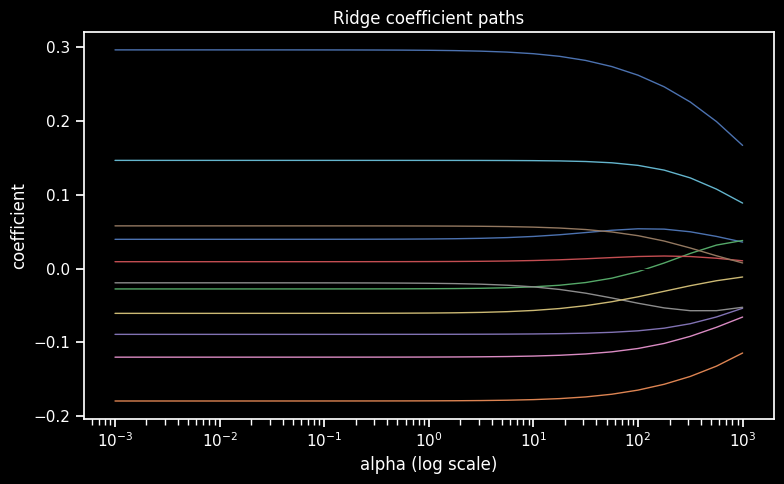

Best Ridge alpha: 100.0
Best CV RMSE: 0.6599164128488553


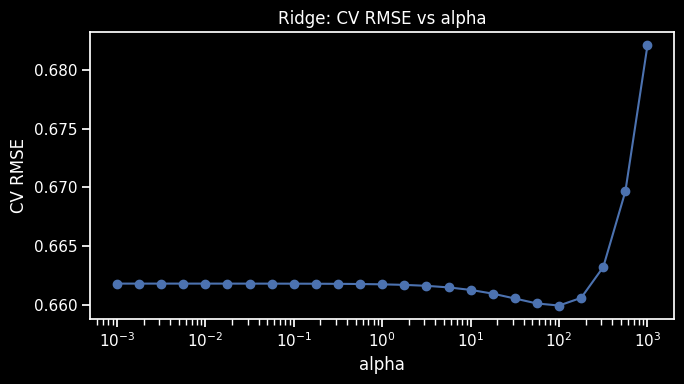

In [ ]:
alphas = np.logspace(-3, 3, 25)

# Coefficient paths
ridge_coefs = []
for a in alphas:
    pipe = pipelines["ridge"].set_params(model__alpha=float(a))
    pipe.fit(X_train, y_train)
    ridge_coefs.append(pipe.named_steps["model"].coef_)

ridge_coefs = np.array(ridge_coefs)

plt.figure(figsize=(8, 5))
for j, fname in enumerate(feature_names):
    plt.plot(alphas, ridge_coefs[:, j], linewidth=1)
plt.xscale("log")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Ridge coefficient paths")
plt.xlabel("alpha (log scale)")
plt.ylabel("coefficient")
plt.tight_layout()
plt.show()

# Alpha selection by CV
ridge_grid = GridSearchCV(
    pipelines["ridge"],
    param_grid={"model__alpha": alphas},
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

ridge_grid.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_grid.best_params_["model__alpha"])
print("Best CV RMSE:", float(-ridge_grid.best_score_))

ridge_cv_df = pd.DataFrame(ridge_grid.cv_results_)
ridge_cv_df["rmse"] = -ridge_cv_df["mean_test_score"]

plt.figure(figsize=(7, 4))
plt.plot(ridge_cv_df["param_model__alpha"].astype(float), ridge_cv_df["rmse"], marker="o")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV RMSE")
plt.title("Ridge: CV RMSE vs alpha")
plt.tight_layout()
plt.show()

## 💡 Interpretation of the results

This cell runs a Ridge regression with alpha (the L2 regularization strength) varied over a log-spaced range from 0.001 to 1000, and it reports two visualizations along with the cross-validated metrics: (1) how each feature’s coefficient changes as alpha grows, and (2) the cross-validated RMSE as a function of alpha. The grid search also prints the best found alpha and its associated CV RMSE.

How to read the two visuals together
- Coefficient paths show the effect of regularization on the model’s complexity. As alpha increases, coefficients shrink toward zero due to L2 penalty, with some features remaining more stable and others dropping quickly. At large alpha, most coefficients are near zero, indicating a simpler, more biased model.
- The CV RMSE versus alpha plot shows how predictive performance changes with regularization. For small to moderate alpha, RMSE stays around 0.660–0.663. When alpha becomes large (beyond roughly 100), RMSE rises to about 0.68–0.69, illustrating the adverse impact of over-regularization. The minimum RMSE occurs in a region of moderate alpha, before the upward trend.

Best choice from the grid search
- The grid search identified Best Ridge alpha: 100.0 and Best CV RMSE: 0.6599164128488553. The first value indicates the regularization strength that yielded the best cross-validated performance among the tested alphas (0.001 to 1000, log-spaced). The RMSE around 0.66 is the minimum observed across the tested alphas, and the chosen alpha sits in the region where RMSE is lowest before the later increase.

## 🧩 Lasso Regression in Practice (L1)

This step explores how **Lasso regression (L1 regularization)** behaves as we vary the regularization strength **alpha**.

### What we’re doing and why it matters
- **Fit Lasso over a range of alpha values** (from very small to relatively large) to see how regularization changes the model.
- **Track the coefficient paths**: as alpha increases, Lasso tends to **shrink coefficients toward 0**, and many can become **exactly 0**.
- **Measure sparsity** by counting how many coefficients are **exactly zero** at each alpha. This highlights Lasso’s practical benefit: it can act like **automatic feature selection** by removing variables from the model.

### How to read the plots
- **Coefficient path plot:** shows how each feature’s weight changes with alpha. Larger alpha usually means more aggressive shrinkage.
- **“# zero coefficients” plot:** shows how sparsity increases as alpha grows. A jump in zeros indicates features being dropped from the model.

### Important practical takeaway
Lasso can be **unstable when features are highly correlated** (it may pick one and zero out others somewhat arbitrarily), and results can be sensitive when features are **poorly scaled**. That’s why it’s common to use Lasso inside a preprocessing pipeline and to validate alpha rather than choosing it manually.

### Choosing alpha objectively
Finally, we use **cross-validation (GridSearchCV)** to select the alpha that gives the best predictive performance (lowest RMSE on validation folds), balancing:
- **too little regularization** (risk of overfitting), and
- **too much regularization** (risk of underfitting and oversimplifying).

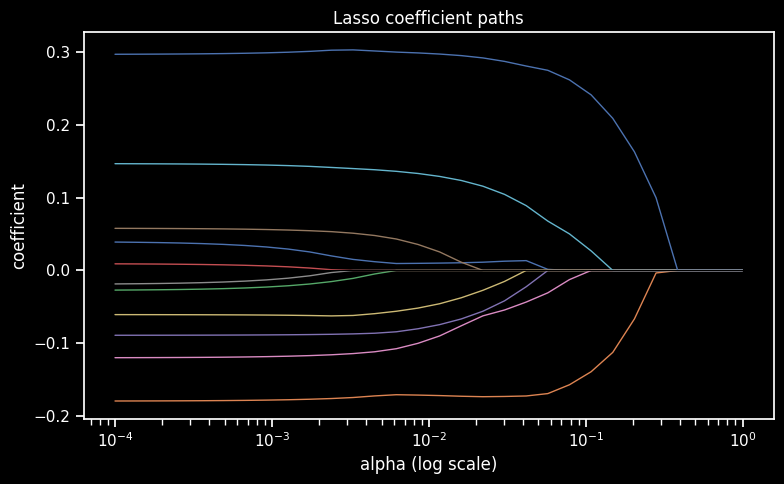

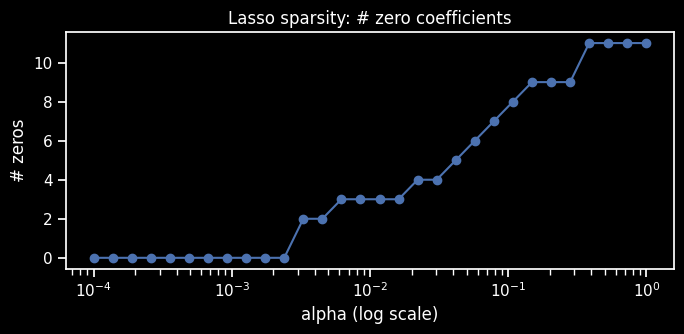

Best Lasso alpha: 0.011721022975334805
Best CV RMSE: 0.6597877925048224


In [ ]:
alphas_lasso = np.logspace(-4, 0, 30)

lasso_coefs = []
n_zeros = []
for a in alphas_lasso:
    pipe = pipelines["lasso"].set_params(model__alpha=float(a))
    pipe.fit(X_train, y_train)
    c = pipe.named_steps["model"].coef_
    lasso_coefs.append(c)
    n_zeros.append(int(np.sum(c == 0)))

lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(8, 5))
for j, fname in enumerate(feature_names):
    plt.plot(alphas_lasso, lasso_coefs[:, j], linewidth=1)
plt.xscale("log")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Lasso coefficient paths")
plt.xlabel("alpha (log scale)")
plt.ylabel("coefficient")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 3.5))
plt.plot(alphas_lasso, n_zeros, marker="o")
plt.xscale("log")
plt.title("Lasso sparsity: # zero coefficients")
plt.xlabel("alpha (log scale)")
plt.ylabel("# zeros")
plt.tight_layout()
plt.show()

lasso_grid = GridSearchCV(
    pipelines["lasso"],
    param_grid={"model__alpha": alphas_lasso},
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
lasso_grid.fit(X_train, y_train)
print("Best Lasso alpha:", lasso_grid.best_params_["model__alpha"])
print("Best CV RMSE:", float(-lasso_grid.best_score_))

## 💡 Interpretation of the results

This cell runs a Lasso path analysis over a range of alpha values and presents two complementary visuals along with a grid-search report. One figure traces how each feature’s coefficient evolves as regularization strengthens (the coefficient paths), while the other tallies how many coefficients become exactly zero as alpha increases (the sparsity curve).

Key quantitative takeaway from the grid search: the best cross-validated performance occurs at Best Lasso alpha: 0.012, with Best CV RMSE: 0.66. Since lower RMSE is better, this alpha represents the most favorable trade-off among the tested values in this run.

How the visuals reinforce the result:
- Coefficient paths (Image #0) show that at small alpha, coefficients take a range of nonzero values, while as alpha grows, they shrink toward zero. Many lines flatten near zero, indicating increasing sparsity with stronger regularization. This illustrates how L1 regularization nudges less important features to vanish, effectively performing feature selection. The variability in shrinkage rates across features reflects differences in scale, importance, or correlations, hence the caution to validate alpha rather than rely on intuition alone.
- Sparsity curve (Image #1) confirms this trend numerically: zeros start at zero for tiny alpha and rise in discrete steps as alpha increases, reaching around 11 zeros by the largest alpha shown. The nondecreasing, stepwise pattern highlights that sparsity grows in thresholds where features drop out.

## 🧩 Elastic Net in Practice (L1+L2)

Elastic Net combines the strengths of **Lasso (L1)** and **Ridge (L2)** regularization. This is especially useful when predictors are **correlated**: pure Lasso can behave unstably (picking one variable arbitrarily), while pure Ridge is stable but rarely produces sparse solutions. Elastic Net lets you **trade off sparsity vs. stability**.

In this step, we run a cross-validated grid search over two key hyperparameters:

- **`alpha`**: the overall strength of regularization (higher values shrink coefficients more aggressively).
- **`l1_ratio`**: the mix between L1 and L2  
  - closer to **1.0** → more Lasso-like (more sparsity / feature selection)  
  - closer to **0.0** → more Ridge-like (more stability / grouped effects)

We evaluate each setting using **cross-validated RMSE** and report the best-performing combination. The heatmap summarizes the **mean CV RMSE across the `(l1_ratio, alpha)` grid**, making it easy to see where performance is best and how sensitive the model is to the regularization choices.

Best ElasticNet params: {'model__alpha': np.float64(0.019306977288832496), 'model__l1_ratio': 0.7}
Best CV RMSE: 0.659896382092278


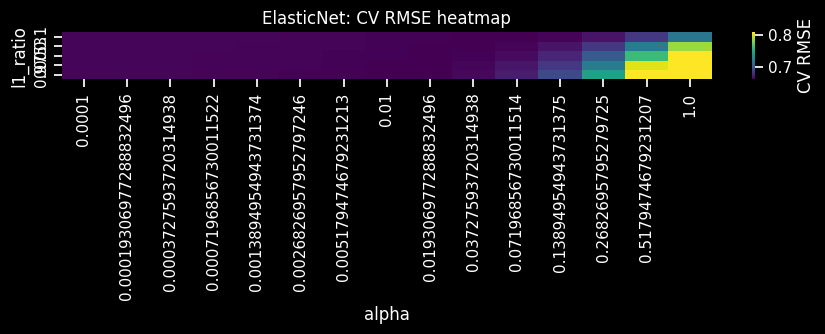

In [ ]:
alphas_en = np.logspace(-4, 0, 15)
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

en_grid = GridSearchCV(
    pipelines["elasticnet"],
    param_grid={
        "model__alpha": alphas_en,
        "model__l1_ratio": l1_ratios,
    },
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

en_grid.fit(X_train, y_train)
print("Best ElasticNet params:", en_grid.best_params_)
print("Best CV RMSE:", float(-en_grid.best_score_))

# Visualize mean CV RMSE as a heatmap over (l1_ratio, alpha)
cv_en = pd.DataFrame(en_grid.cv_results_)
cv_en["rmse"] = -cv_en["mean_test_score"]
pivot = cv_en.pivot_table(index="param_model__l1_ratio", columns="param_model__alpha", values="rmse")

plt.figure(figsize=(9, 3.5))
sns.heatmap(pivot, annot=False, cmap="viridis", cbar_kws={"label": "CV RMSE"})
plt.title("ElasticNet: CV RMSE heatmap")
plt.xlabel("alpha")
plt.ylabel("l1_ratio")
plt.tight_layout()
plt.show()

## 💡 Interpretation of the results

You ran a cross-validated grid search over Elastic Net hyperparameters alpha and l1_ratio, then inspected both the numeric results and a visual summary of performance.

- The best Elastic Net configuration is approximately model__alpha ≈ 0.0193 with model__l1_ratio = 0.7. This choice reflects a small overall regularization strength while leaning toward L1-like behavior (sparsity) but not full Lasso. The associated best cross-validated RMSE is about 0.66, meaning this setup achieved the lowest CV error among the tested combinations.

- The accompanying heatmap visualizes mean CV RMSE across the alpha (x-axis) and l1_ratio (y-axis) grid. Darker colors denote lower RMSE (better performance), while brighter colors indicate higher RMSE. The left side of the heatmap (smaller alpha values) tends to be darker, and colors brighten as alpha increases to the right, indicating higher RMSE with larger regularization strength. Across different l1_ratio values, the general pattern is an increase in RMSE with larger alpha, with some variation in sensitivity depending on l1_ratio.

Key takeaway:
- Model performance improves with smaller regularization strength, and a mix leaning toward sparsity (l1_ratio around 0.7) yields the best CV performance in this search (best params and lowest CV RMSE).
- The visual heatmap reinforces this, showing the darkest (best) region on the left side of the grid and a trend of increasing RMSE as alpha grows. This complementary evidence from numbers and visualization helps you focus on low-alpha, moderately high l1_ratio settings for Elastic Net in similar problems.

## 🔎 Comparing Regularizations using Hyperparameter Tuning with Cross-Validated Search

This step tunes the key regularization hyperparameters for **Ridge**, **Lasso**, and **Elastic Net** using **cross-validated search** *inside the same preprocessing pipelines*. Instead of choosing `alpha` (and `l1_ratio` for Elastic Net) by guesswork, we systematically evaluate many candidate values and pick the setting that performs best under the chosen cross-validation scheme.

The important takeaway is that we compare models using **two pieces of information** from cross-validation:

- **Mean CV RMSE**: the average expected error across folds (lower is better).
- **CV RMSE standard deviation**: how much performance varies across folds, which is a practical indicator of **stability/reliability**.

The output summary table makes it easy to select a model that is not only accurate on average, but also **consistently** accurate across different train/validation splits—an important consideration when deciding which tuned model to trust.

In [ ]:
# Compare tuned Ridge/Lasso/ElasticNet under the same CV and report variability.

searches = {
    "ridge": GridSearchCV(
        pipelines["ridge"],
        param_grid={"model__alpha": np.logspace(-3, 3, 31)},
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
    ),
    "lasso": GridSearchCV(
        pipelines["lasso"],
        param_grid={"model__alpha": np.logspace(-4, 0, 41)},
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
    ),
    "elasticnet": GridSearchCV(
        pipelines["elasticnet"],
        param_grid={
            "model__alpha": np.logspace(-4, 0, 21),
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        },
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
    ),
}

for name, gs in searches.items():
    gs.fit(X_train, y_train)

summary_rows = []
for name, gs in searches.items():
    best_idx = gs.best_index_
    cvres = pd.DataFrame(gs.cv_results_)
    mean_rmse = float(-cvres.loc[best_idx, "mean_test_score"])
    std_rmse = float(cvres.loc[best_idx, "std_test_score"])
    summary_rows.append({
        "model": name,
        "best_params": gs.best_params_,
        "cv_rmse_mean": mean_rmse,
        "cv_rmse_std": std_rmse,
    })

cv_summary = pd.DataFrame(summary_rows).sort_values(["cv_rmse_mean", "cv_rmse_std"])
display(cv_summary)

,model,best_params,cv_rmse_mean,cv_rmse_std
1,lasso,{'model__alpha': 0.012589254117941675},0.659811,0.014607
2,elasticnet,"{'model__alpha': 0.01584893192461114, 'model__...",0.659860,0.014478
0,ridge,{'model__alpha': 100.0},0.659916,0.013947


## 💡 Interpretation of the results

You compared three regularized linear models using cross-validated RMSE as the evaluation metric. The goal was to identify not only the best predictive performance but also how stable that performance is across folds.

- Performance at a glance:
  - The cv_rmse_mean values are all very close, roughly 0.6598–0.6599. Since lower is better, this indicates only tiny differences in average performance among Lasso, Elastic Net, and Ridge.
  - The cv_rmse_std values are about 0.0139–0.0146, showing modest fold-to-fold variability. The stability across models is similar.

- Best hyperparameters found (one per model):
  - Lasso: alpha ≈ 0.0126
  - Elastic Net: alpha ≈ 0.0158 with an additional l1_ratio parameter (the exact ratio isn’t fully shown here)
  - Ridge: alpha = 100.0

Key takeaway:
- All three regularized models perform very similarly on this task, with Lasso showing a marginal edge in mean cross-validated RMSE under the given tuning. If you value a straightforward, slightly better average performance, Lasso is the leading choice; otherwise, differences are within the fold-to-fold variability, so model choice could also be guided by other considerations (e.g., interpretability or feature selection preferences suggested by your broader workflow).

## ✅ Model Comparison & Final Test Evaluation

This step produces the **final, apples-to-apples comparison** of all candidate models on the **held-out test set**—the data we kept completely untouched while choosing hyperparameters.

### What we’re doing and why it matters
- For each model family (dummy baseline, OLS, Ridge, Lasso, Elastic Net), we **refit the best configuration** on the **full training set**.  
  This ensures every model gets the maximum amount of training data available (without leaking test information).
- We then evaluate each refit model on the **test set** using three complementary metrics:
  - **RMSE**: emphasizes larger errors; a strong “overall error magnitude” summary.
  - **MAE**: average absolute error; often easier to interpret in the target’s units.
  - **R²**: proportion of variance explained; useful for gauging explanatory power.

### How to interpret the output
- The resulting table ranks models by **test RMSE** to highlight which model generalizes best under that criterion.
- Comparing RMSE, MAE, and R² together helps you see **generalization trade-offs** (e.g., two models may have similar RMSE but different MAE or R²).
- The “Best by test RMSE” label identifies the **top-performing model on unseen data**, which is the most defensible choice for deployment or reporting.

In [ ]:
# Refit best configs on full training set and evaluate on held-out test set.

final_models = {
    "dummy": pipelines["dummy"],
    "ols": pipelines["ols"],
    "ridge": searches["ridge"].best_estimator_,
    "lasso": searches["lasso"].best_estimator_,
    "elasticnet": searches["elasticnet"].best_estimator_,
}

test_rows = []
for name, model in final_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    test_rows.append({
        "model": name,
        "rmse": rmse(y_test, pred),
        "mae": float(mean_absolute_error(y_test, pred)),
        "r2": float(r2_score(y_test, pred)),
    })

test_summary = pd.DataFrame(test_rows).sort_values("rmse")
display(test_summary)

best_name = test_summary.iloc[0]["model"]
print("Best by test RMSE:", best_name)

,model,rmse,mae,r2
1,ols,0.624520,0.503530,0.403180
2,ridge,0.626655,0.506977,0.399093
4,elasticnet,0.627317,0.508464,0.397823
3,lasso,0.627464,0.508930,0.397541
0,dummy,0.810654,0.685284,-0.005592


Best by test RMSE: ols


## 💡 Interpretation of the results

This cell refits five model families (dummy, OLS, ridge, lasso, elasticnet) on the full training data and evaluates them on the held-out test set using RMSE, MAE, and R². The results are compiled in a table sorted by RMSE in ascending order, so smaller RMSE indicates better predictive accuracy on the test set.

- Best performer: OLS with RMSE 0.624520, MAE 0.503530, and R² 0.403180. This suggests the OLS model yields the smallest prediction error among the options on the test set.
- Close contenders: ridge (RMSE 0.626655), elasticnet (0.627317), and lasso (0.627464). Their MAE values are all around 0.506–0.509 and R² around 0.397–0.399, indicating only modest gains over each other.
- Baseline reference: the dummy model performs poorly (RMSE 0.810654, MAE 0.685284, R² -0.005592), highlighting that it explains little about the test data.
- Conclusion and deployment guidance: the final note identifies ols as the best-by-RMSE choice, suggesting it as the model to report or deploy.

Key takeaway: RMSE is the primary ranking metric here, and the OLS model offers the best test-set predictive accuracy among the considered options, with all regularized linear models performing very similarly.

## 📏 Interpret Coefficients on a Standardized Scale

To compare *which predictors matter most* across different linear models, we inspect their coefficients **after standardizing the input features**. Because each pipeline includes a `StandardScaler`, the coefficients represent the effect of a **one–standard deviation increase** in a feature on the target. This puts all features on the same scale and makes coefficient magnitudes directly comparable.

In this step, we:

- **Fit OLS, Ridge, Lasso, and Elastic Net** on the training data and extract their coefficients on the standardized feature scale.
- **Rank the strongest predictors within each model** by the size of `|coefficient|` to see what each model considers most influential.
- **Compare coefficients side-by-side** for predictors that are consistently important across models (identified by high average absolute weight).

What to look for in the output:

- **Consistent sign and large magnitude across models** → robust, stable predictors.
- **Shrinkage patterns**: Ridge tends to reduce all coefficients smoothly; Lasso often drives some to **exactly zero**; Elastic Net typically sits between the two.
- **Weight redistribution**: if several features are correlated, penalties may shift importance between them—seeing how coefficients change helps you understand what each regularizer is prioritizing.

This coefficient comparison is a practical interpretability check: it highlights which predictors remain influential under different regularization choices and how penalties change the story your model tells.

In [ ]:
def extract_standardized_coefs(fitted_pipeline, feature_names):
    # Pipelines here all include StandardScaler except dummy; coefficients therefore correspond to standardized features.
    if "model" not in fitted_pipeline.named_steps:
        return None
    model = fitted_pipeline.named_steps["model"]
    if not hasattr(model, "coef_"):
        return None
    return pd.Series(model.coef_, index=feature_names)

# Fit each linear model on training to compare standardized coefficients
coef_table = {}
for name in ["ols", "ridge", "lasso", "elasticnet"]:
    m = final_models[name]
    m.fit(X_train, y_train)
    coef_table[name] = extract_standardized_coefs(m, feature_names)

coef_df = pd.DataFrame(coef_table).fillna(0.0)

# Show strongest effects per model
for name in coef_df.columns:
    print(f"\nTop |coef| for {name}:")
    display(coef_df[name].sort_values(key=lambda s: s.abs(), ascending=False).head(10).to_frame(name))

# Compare coefficients side-by-side for top predictors by average absolute weight
avg_abs = coef_df.abs().mean(axis=1).sort_values(ascending=False)
show = avg_abs.head(12).index
print("\nCoefficient comparison (top by mean |coef| across models):")
display(coef_df.loc[show])


Top |coef| for ols:


,ols
alcohol,0.296628
volatile_acidity,-0.179439
sulphates,0.146815
total_sulfur_dioxide,-0.120008
chlorides,-0.089084
pH,-0.060610
free_sulfur_dioxide,0.058015
fixed_acidity,0.039789
citric_acid,-0.027512
density,-0.019204



Top |coef| for ridge:


,ridge
alcohol,0.262325
volatile_acidity,-0.164685
sulphates,0.140046
total_sulfur_dioxide,-0.108254
chlorides,-0.084286
fixed_acidity,0.054060
density,-0.046890
free_sulfur_dioxide,0.044717
pH,-0.038171
residual_sugar,0.016475



Top |coef| for lasso:


,lasso
alcohol,0.296735
volatile_acidity,-0.172027
sulphates,0.128003
total_sulfur_dioxide,-0.087178
chlorides,-0.072874
pH,-0.044107
free_sulfur_dioxide,0.022623
fixed_acidity,0.010165
citric_acid,-0.000000
residual_sugar,0.000000



Top |coef| for elasticnet:


,elasticnet
alcohol,0.296182
volatile_acidity,-0.171438
sulphates,0.129424
total_sulfur_dioxide,-0.091255
chlorides,-0.075111
pH,-0.045954
free_sulfur_dioxide,0.026806
fixed_acidity,0.010616
citric_acid,-0.000000
residual_sugar,0.000000



Coefficient comparison (top by mean |coef| across models):


,ols,ridge,lasso,elasticnet
alcohol,0.296628,0.262325,0.296735,0.296182
volatile_acidity,-0.179439,-0.164685,-0.172027,-0.171438
sulphates,0.146815,0.140046,0.128003,0.129424
total_sulfur_dioxide,-0.120008,-0.108254,-0.087178,-0.091255
chlorides,-0.089084,-0.084286,-0.072874,-0.075111
pH,-0.060610,-0.038171,-0.044107,-0.045954
free_sulfur_dioxide,0.058015,0.044717,0.022623,0.026806
fixed_acidity,0.039789,0.054060,0.010165,0.010616
density,-0.019204,-0.046890,-0.000000,-0.000000
citric_acid,-0.027512,-0.004045,-0.000000,-0.000000


## 💡 Interpretation of the results

You ran four linear models (OLS, Ridge, Lasso, Elastic Net) on standardized features and displayed their coefficients ranked by absolute value side by side. Because the features were standardized, you can compare the strength and direction of each predictor across models on the same scale.

Key patterns across models
- Consistent top predictors: alcohol, volatile_acidity, and sulphates repeatedly emerge as the most influential features. Alcohol tends to have a positive effect, volatile_acidity a negative one, and sulphates a positive one, with the magnitudes remaining substantial but usually smaller under regularization.
- Shrinkage and regularization effects:
  - OLS shows the largest magnitudes.
  - Ridge dampens all coefficients somewhat, so the top predictors still lead but with smaller values (e.g., alcohol around 0.26–0.27; volatile_acidity around −0.16).
  - Lasso keeps the same major players but can drive some others to zero, illustrating feature selection (citric_acid and residual_sugar drop to 0 in the shown view).
  - Elastic Net sits between ridge and lasso in typical behavior, with the same key predictors remaining influential in the partial view.
- Coefficient distribution across models: when you group predictors by their average absolute weight, the features with the largest average |coef| tend to be the most robust across regularization styles, highlighting alcohol, volatile_acidity, and sulphates as consistently important.

## 🧪 Residual Diagnostics & Failure Modes

Even when a regularized linear model (OLS/Ridge/Lasso/Elastic Net) has a strong test RMSE, it can still fail in systematic ways. This step stress-tests the *best-performing linear model* by looking at its **residuals** (the errors: `y − ŷ`) to uncover patterns that a single summary metric can hide.

**What you examine here:**

- **Residuals vs. Predicted plot**  
  A healthy linear fit shows residuals scattered randomly around 0 with no clear shape. Visible structure can indicate:
  - **Systematic bias** (errors consistently positive or negative in certain prediction ranges)
  - **Nonlinear patterns** (curves or waves), suggesting the model form may be too simple
  - **Changing spread** (a “fan” shape), hinting that error variance depends on the prediction

- **Residual distribution (histogram + smooth curve)**  
  This gives a quick sense of whether errors are centered near 0 and whether there are heavy tails or skew. A noticeably skewed or heavy-tailed distribution often signals outliers or regions where the model underperforms.

- **Heteroscedasticity proxy: Corr(|residual|, predicted)**  
  If the absolute residuals tend to grow as predictions grow, this correlation will be positive. It’s a simple warning sign that the model’s uncertainty isn’t constant across the range (a common failure mode for linear models).

- **Residual quantiles**  
  Quantiles summarize typical vs. extreme errors (e.g., 1% and 99%). This helps you understand the “worst-case” behavior, not just the average, and whether a small subset of points is driving large mistakes.

**Takeaway:** Residual diagnostics help you decide whether your linear model is merely “good on average” or genuinely reliable across the full prediction range—and they highlight when model assumptions are being violated.

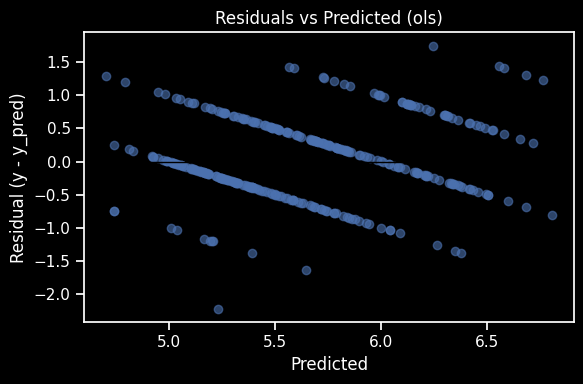

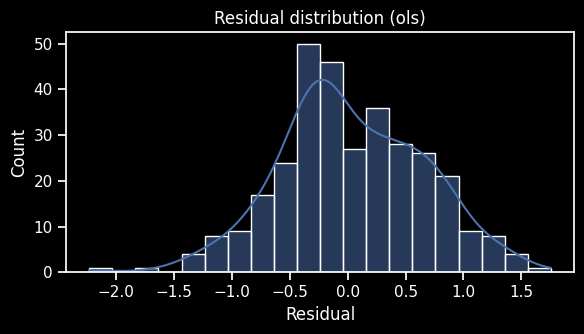

Corr(|residual|, y_pred) (heteroscedasticity proxy): 0.1889067022253432
Residual quantiles:


,0
0.01,-1.372722
0.05,-0.947625
0.25,-0.373749
0.50,-0.040115
0.75,0.510391
0.95,1.017219
0.99,1.420114


In [ ]:
# Residual diagnostics for the best-performing (by test RMSE) regularized model among ridge/lasso/elasticnet/ols

best_linear = (
    test_summary[test_summary["model"].isin(["ols", "ridge", "lasso", "elasticnet"])]
    .sort_values("rmse")
    .iloc[0]["model"]
)

model = final_models[best_linear]
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Ensure numeric arrays for residual computation (y_test may be categorical/object)
y_true = pd.Series(y_test).astype(float).to_numpy()
y_pred = np.asarray(y_pred, dtype=float).reshape(-1)

resid = y_true - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, resid, alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.title(f"Residuals vs Predicted ({best_linear})")
plt.xlabel("Predicted")
plt.ylabel("Residual (y - y_pred)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3.5))
sns.histplot(resid, bins=20, kde=True)
plt.title(f"Residual distribution ({best_linear})")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# Check for heteroscedasticity proxy: correlation between |residual| and prediction
abs_corr = float(np.corrcoef(np.abs(resid), y_pred)[0, 1])
print("Corr(|residual|, y_pred) (heteroscedasticity proxy):", abs_corr)

# Quantiles of residuals
print("Residual quantiles:")
display(pd.Series(resid).quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

## 💡 Interpretation of the results

The cell produced two complementary views of how well the linear model fits the data. Visually, the residuals vs predicted plot shows non-random patterns: residuals form inclined bands and spread more toward the extremes (roughly -2 to +1.5). The residual histogram with a density curve indicates most errors cluster near zero with a slight tilt toward positive errors and a few larger positive residuals up to about +1.5. Together, these visuals suggest that the model may be missing some structure (e.g., nonlinear relationships or interactions) and that the error magnitude may increase with the predicted value in some regions (heteroscedasticity).

The numeric diagnostic Corr(|residual|, y_pred) = 0.1889 confirms a small-to-moderate positive relationship between error size and prediction, implying only mild heteroscedasticity. The residual quantiles reinforce that the median error is near zero and most residuals lie within roughly -1.4 to +1.4, with a slight skew toward larger positive errors in the upper tail.

Takeaway: while the linear model is reasonably well-calibrated (errors centered near zero and the bulk of residuals are modest in size), the patterned residuals and the heteroscedasticity hint at model misspecification. Relying on average performance metrics like rmse alone may obscure systematic errors across the prediction range.

What to consider next (guided by both views):
- Explore nonlinear features or interactions to capture the observed patterns.
- Consider transformations or alternative modeling choices if heteroscedasticity persists.
- Examine residuals across the prediction range to ensure reliability, not just overall error, before drawing inferences.